# Time Series Anomaly Detection

* Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

**Bonus:**

* Can you label students who are viewing both the web dev and data science curriculum?
* Can you label students by the program they are in? Can you label users by student vs. staff? 
* What are Zach, Maggie, David, and Ryan's ids?

In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

In [2]:
def wrangle_access_logs():
    # acquire
    colnames=['date', "time", 'destination', 'unknown_1',
              'unknown_2', "ip"]
    df_orig = pd.read_csv("curriculum-access.txt",          
                     engine='python',
                     header=None,
                     index_col=False,
                     names=colnames,
                     sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                     na_values='"-"',
                         )
    
    # join the date and time
    df_orig["time_stamp"] = pd.to_datetime(df_orig.date + " " + df_orig.time)
    
    # Drop columns since it is all in the time_stamp
    df_orig.drop(columns=["time", "date"], inplace = True)
    
    # Sort values by date
    df = df_orig.sort_values(by="time_stamp")
    
    # Change value types
    df["unknown_2"] = df["unknown_2"].astype(float)
    
    # Rename the unknown columns
    df = df.rename(columns={"unknown_1": "user_id", "unknown_2": "cohort"})
    
    # Set the index to date
    df = df.set_index("time_stamp")
    
    # Create new columns detailing if student is web_dev or data_science
    web_dev = df[df.destination == "java-ii"].groupby("user_id").user_id.sum().index

    df['is_wd'] = df['user_id'].apply(lambda x: 1 if x in web_dev else 0)

    ds = df[df.destination == "1-fundamentals/1.1-intro-to-data-science"].groupby("user_id").user_id.sum().index

    df['is_ds'] = df['user_id'].apply(lambda x: 1 if x in ds else 0)
    
    return df

In [3]:
logs = wrangle_access_logs()

In [4]:
logs

,destination,user_id,cohort,ip,is_wd,is_ds
time_stamp,,,,,,
2018-01-26 09:55:03,/,1,8.0,98.106.20.62,1,1
2018-01-26 09:56:02,java-ii,1,8.0,98.106.20.62,1,1
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,98.106.20.62,1,1
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,98.106.20.62,1,1
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,98.106.20.62,1,0
...,...,...,...,...,...,...
2020-05-15 15:01:40,java-ii/file-io,602,56.0,48.188.241.68,1,0
2020-05-15 15:01:54,9-timeseries/3-prep,582,55.0,48.135.163.38,0,1
2020-05-15 15:03:37,jquery/ajax/requests-and-responses,637,57.0,71.121.18.17,0,0


## Look at the overall access logs, and see if there are any anomalies

Text(0.5, 1.0, 'Total number of destinations requested per day')

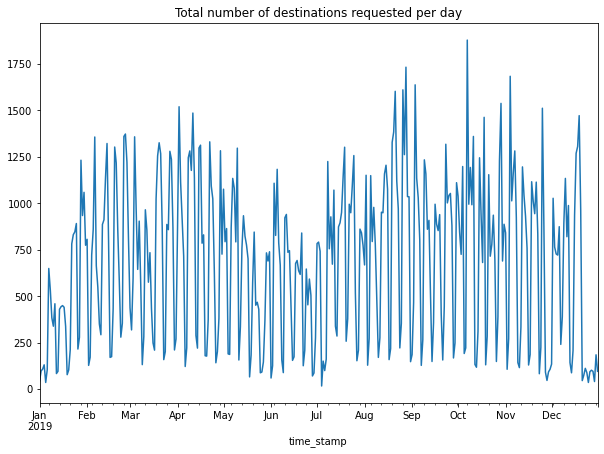

In [5]:
# Since it is a large ds, we will look at only 2019 to begin with
# We will resample the data so that it is daily
# We will measure the number of destinations per day. 

logs["2019"].groupby("time_stamp").destination.count().resample("D").sum().plot.line(figsize=(10, 7))
plt.title("Total number of destinations requested per day")

In [6]:
# We will look to do a report for March 3rd, 2019. To do that - we need to look at the day before.

# df[df.destination > 1.3]

In [7]:
# We can see that our value in question is still the second to last one.
df = logs["2019-02-20":"2019-03-03"].groupby("time_stamp")[["destination"]].count().resample("D").mean()
df = df.rename(columns={"destination":"destination_count"})
df.tail()

,destination_count
time_stamp,
2019-02-27,1.028668
2019-02-28,1.038710
2019-03-01,1.033019
2019-03-02,1.019231
2019-03-03,1.374134


In [8]:
# to calculate percent - b
def create_pct_b(df, target_variable, span, bound=3):
    span = span
    ema = df.ewm(span=span, adjust=False).mean()
    stdev = df.ewm(span=span, adjust=False).std()
    
    previous_val = pd.DataFrame({'previous_val': df[target_variable]})
    prev_day_df = stdev.join(ema, how='left', lsuffix="_x")

    prev_day_df = prev_day_df.join(previous_val, how='left')

    prev_day_df.fillna(0, inplace = True)

    my_index = df.index[1:]

    prev_day_df = prev_day_df[:-1].reset_index().set_index(my_index)

    prev_day_df.drop(columns=["time_stamp", target_variable + "_x", target_variable], inplace=True)

    target_val = pd.DataFrame({'target_val': df[target_variable]})

    df = target_val.join(prev_day_df, how='left')

    df.fillna(0, inplace = True)

    df["ema"] = ema
    df["stdev"] = stdev

    # compute the upper and lower band
    df['ub'] = df['ema'] + bound*df['stdev']
    df['lb'] = df['ema'] - bound*df['stdev']

    # compute percent b
    df['pct_b'] = (df['target_val'] - df['lb']) / (df['ub'] - df['lb'])
    
    return df

In [12]:
# Test the function
df_1 = create_pct_b(df, "destination_count", 2)
df_1.head()

,target_val,previous_val,ema,stdev,ub,lb,pct_b
time_stamp,,,,,,,
2019-02-20,1.042845,0.000000,1.042845,NaN,NaN,NaN,NaN
2019-02-21,1.025060,1.042845,1.030988,0.012576,1.068716,0.993260,0.421433
2019-02-22,1.013937,1.025060,1.019621,0.013352,1.059677,0.979565,0.429054
2019-02-23,1.000000,1.013937,1.006540,0.015169,1.052048,0.961032,0.428141
2019-02-24,1.002833,1.000000,1.004069,0.009095,1.031354,0.976784,0.477354


# Main Loop to Dedect Activity

In [15]:
df_1

,target_val,previous_val,ema,stdev,ub,lb,pct_b
time_stamp,,,,,,,
2019-02-20,1.042845,0.000000,1.042845,NaN,NaN,NaN,NaN
2019-02-21,1.025060,1.042845,1.030988,0.012576,1.068716,0.993260,0.421433
2019-02-22,1.013937,1.025060,1.019621,0.013352,1.059677,0.979565,0.429054
2019-02-23,1.000000,1.013937,1.006540,0.015169,1.052048,0.961032,0.428141
2019-02-24,1.002833,1.000000,1.004069,0.009095,1.031354,0.976784,0.477354
2019-02-25,1.028744,1.002833,1.020519,0.017268,1.072324,0.968715,0.579387
2019-02-26,1.070148,1.028744,1.053605,0.034555,1.157271,0.949939,0.579790
2019-02-27,1.028668,1.070148,1.036980,0.025969,1.114889,0.959072,0.446652
2019-02-28,1.038710,1.028668,1.038133,0.015038,1.083246,0.993020,0.506389


In [16]:
df = logs.groupby("time_stamp")[["destination"]].count().resample("D").sum()
date = 2
active = True
while active:
    if date < df.shape[0]:
        date += 1
        df_1 = df.iloc[:date]
        df_1 = create_pct_b(df, "destination", 2)
    else:
        active = False
       
years = ["2018", "2019", "2020"]
for col in years:
    if (df_1.pct_b > 0.582).sum() == 0:
        print(f"No anomaly activity detected in {col}")
    else:
        print()
        print(f"Suscicious report(s) in {col}:")
        print("-------")
        print(f"Number of high reports: {df_1[col][df_1[col].pct_b >= 0.582].shape[0]}")
        print(df_1[col][df_1[col].pct_b >= 0.582][["target_val", "pct_b"]].sort_values(by="pct_b", ascending=False))
        print()
        print(f"Number of low reports: {df_1[col][df_1[col].pct_b < 0].shape[0]}")
        print(df_1[col][df_1[col].pct_b < 0][["target_val", "pct_b"]].sort_values(by="pct_b", ascending=False))
        print()


Suscicious report(s) in 2018:
-------
Number of high reports: 10
            target_val     pct_b
time_stamp                      
2018-11-26         740  0.583154
2018-07-23        1027  0.583033
2018-05-29         749  0.582886
2018-02-20         822  0.582646
2018-04-03         965  0.582633
2018-06-11        1267  0.582309
2018-05-21         531  0.582244
2018-07-09         743  0.582111
2018-02-27        1171  0.582076
2018-08-27        1446  0.582009

Number of low reports: 0
Empty DataFrame
Columns: [target_val, pct_b]
Index: []


Suscicious report(s) in 2019:
-------
Number of high reports: 8
            target_val     pct_b
time_stamp                      
2019-01-07         649  0.583146
2019-12-02        1027  0.583052
2019-07-08        1225  0.583038
2019-01-22         782  0.582609
2019-04-29        1283  0.582186
2019-04-22        1331  0.582133
2019-03-18        1023  0.582127
2019-02-25        1360  0.582099

Number of low reports: 0
Empty DataFrame
Columns: [target_va

Text(0.5, 1.0, 'Percent_b score over time')

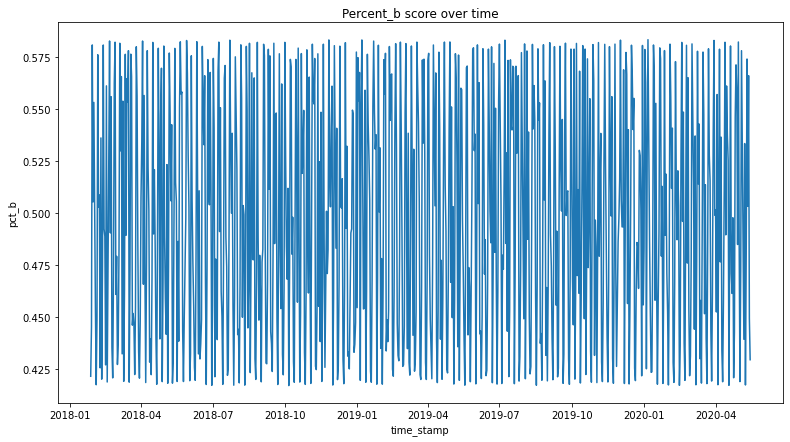

In [20]:
plt.figure(figsize=(13, 7))
sns.lineplot(data=df_1, x=df_1.index, y="pct_b")
plt.title("Percent_b score over time")

## No strange activity happened overall. What if we look at it by cohort?

Text(0.5, 1.0, 'Number of destination in the Curie Cohort')

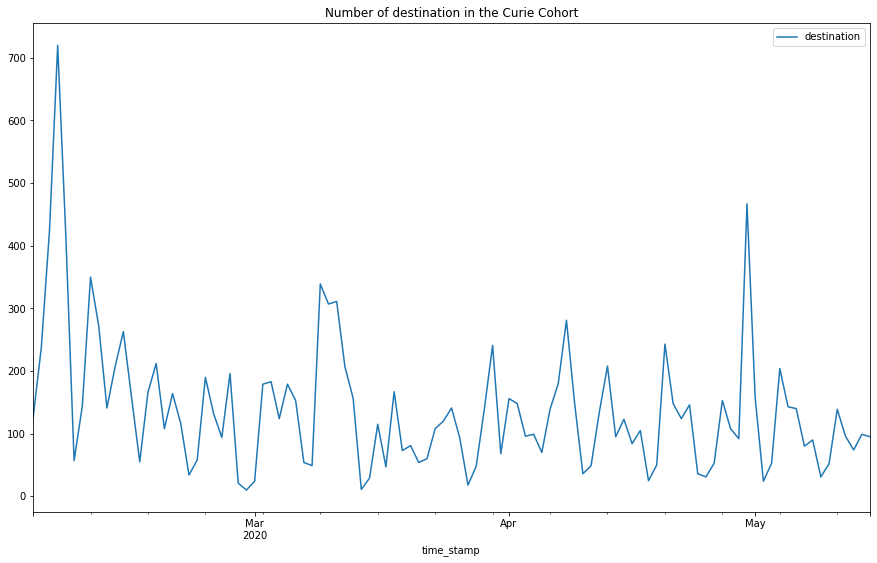

In [21]:
logs[logs.cohort == 55].groupby("time_stamp")[["destination"]].count().resample("D").sum().plot.line(figsize=(15,9))
plt.title("Number of destination in the Curie Cohort")

In [22]:
df = pd.DataFrame()
cohorts = logs.cohort.value_counts().index.sort_values()
cohort = 0
active = True
while active:
    if cohort < cohorts.shape[0]:
        test = logs[logs.cohort == cohorts[cohort]].groupby("time_stamp")[["destination"]].count().resample("D").sum()
        value = create_pct_b(test, "destination", 2)
        value["cohort"] = cohorts[cohort]
        df = pd.concat([df, value])
        cohort += 1
        if df.pct_b[-1] > 1:
            print(f'There is a high anomaly detected in cohort {cohorts[cohort]} on {df.iloc[-1].name}')
        elif df.pct_b[-1] < 0:
            print(f'There is a low anomaly detected in cohort {cohorts[cohort]} on {df.iloc[-1].name}')
    else:
        active = False

years = ["2018", "2019", "2020"]
for col in years:
    if (df_1.pct_b > 1).sum() == 0:
        print(f"No anomaly activity detected in {col}")
    elif (df_1.pct_b > 1).sum() > 0:
        print()
        print(f"Suscicious report(s) in {col}:")
        print("-------")
        print(f"Number of high reports: {df[col][df[col].pct_b >= 1].shape[0]}")
        print(df[col][df[col].pct_b >= 1][["cohort","target_variable", "pct_b"]])
        print()
        print(f"Number of high reports: {df[col][df[col].pct_b >= 1].shape[0]}")
        print(df[col][df[col].pct_b < 0][["cohort","target_variable", "pct_b"]])
        print()
        

No anomaly activity detected in 2018
No anomaly activity detected in 2019
No anomaly activity detected in 2020


In [23]:
# Data frame with number of destinations, per day, by cohort
df

,target_val,previous_val,ema,stdev,ub,lb,pct_b,cohort
time_stamp,,,,,,,,
2018-01-26,19,0.0,19.000000,NaN,NaN,NaN,NaN,1.0
2018-01-27,0,19.0,6.333333,13.435029,46.638420,-33.971753,0.421433,1.0
2018-01-28,0,0.0,2.111111,8.497058,27.602286,-23.380064,0.458591,1.0
2018-01-29,22,0.0,15.370370,14.136890,57.781039,-27.040299,0.578160,1.0
2018-01-30,12,22.0,13.123457,8.460814,38.505897,-12.258984,0.477869,1.0
...,...,...,...,...,...,...,...,...
2020-05-11,171,85.0,151.094689,92.000811,427.097123,-124.907745,0.536060,57.0
2020-05-12,261,171.0,224.364896,90.498102,495.859201,-47.129409,0.567469,57.0
2020-05-13,288,261.0,266.788299,67.303149,468.697746,64.878851,0.552528,57.0


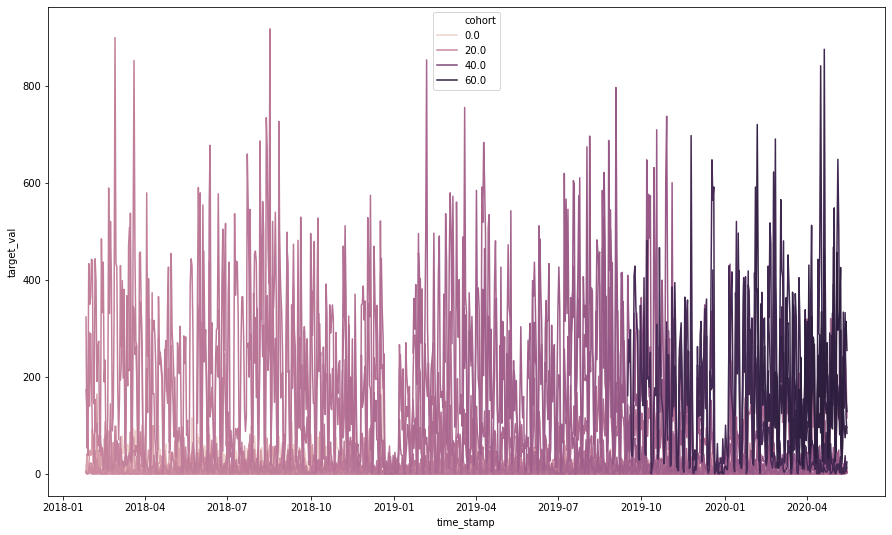

In [24]:
plt.figure(figsize=(15,9))
sns.lineplot(data=df, x=df.index, y="target_val", hue="cohort")

It doesn't seem that there is any extreme activity within cohorts either. I suppose that I am still looking at it too big picture. 

## Can we look at it by user?

In [25]:
# How many users are there?
logs.user_id.unique().shape[0]

650

Text(0.5, 1.0, 'Number of destination for one student')

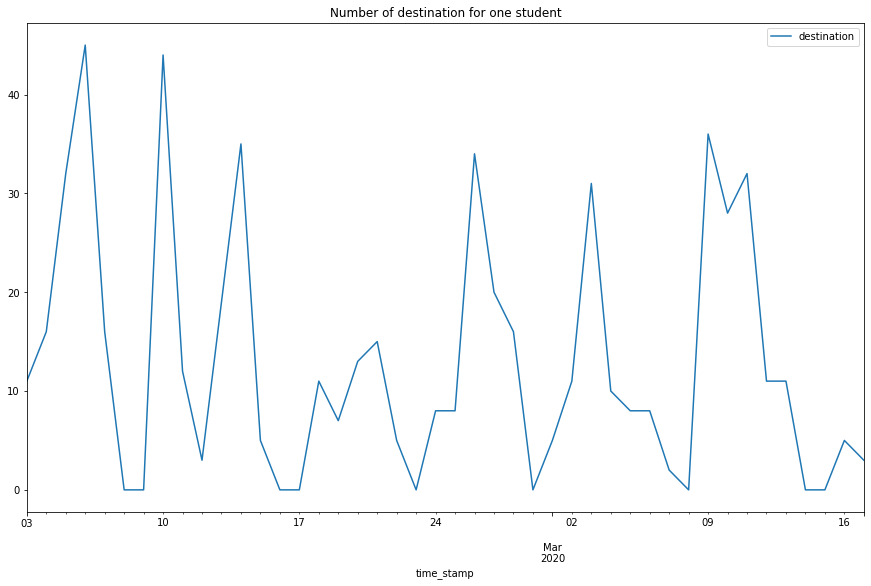

In [26]:
logs[logs.user_id == 587].groupby("time_stamp")[["destination"]].count().resample("D").sum().plot.line(figsize=(15,9))
plt.title("Number of destination for one student")

In [27]:
ds = logs[(logs.is_ds == 1) & (logs.is_wd == 0)]
ds = ds.groupby(["time_stamp", "user_id"])[["destination"]].count()
ds

,,destination
time_stamp,user_id,
2018-02-05 21:40:45,88,1
2018-02-09 15:50:56,94,1
2018-02-09 15:51:00,94,1
2018-02-09 15:51:01,94,1
2018-02-09 15:51:03,94,1
...,...,...
2020-05-15 14:46:46,591,1
2020-05-15 14:47:01,591,1
2020-05-15 14:49:50,591,1


In [28]:
df = pd.DataFrame()
users = logs.user_id.value_counts().index.sort_values()
user = 0
active = True
while active:
    if user < users.shape[0]:
        test = logs[logs.user_id == users[user]].groupby("time_stamp")[["destination"]].count().resample("D").sum()
        value = create_pct_b(test, "destination", 2)
        value["user_id"] = users[user]
        df = pd.concat([df, value])
        user += 1
        if df.pct_b[-1] > 1:
            print(f'There is a high anomaly detected in user {users[user]} on {df.iloc[-1].name}')
        elif df.pct_b[-1] < 0:
            print(f'There is a low anomaly detected in cohort {users[user]} on {df.iloc[-1].name}')
    else:
        active = False

years = ["2018", "2019", "2020"]
for col in years:
    if (df.pct_b > 1).sum() == 0:
        print(f"No anomaly activity detected in {col}")
    else:
        print()
        print(f"Suspicious report(s) in {col}:")
        print("-------")
        print(f"Number of high reports: {df[col][df[col].pct_b >= 1].shape[0]}")
        print(df[col][df[col].pct_b >= 1][["user_id","target_val", "pct_b"]].sort_values(by="pct_b", ascending=False))
        print()
        print(f"Number of low reports: {df[col][df[col].pct_b < 0].shape[0]}")
        print(df[col][df[col].pct_b < 0][["user_id","target_val", "pct_b"]].sort_values(by="pct_b", ascending=False))
        print()

No anomaly activity detected in 2018
No anomaly activity detected in 2019
No anomaly activity detected in 2020


In [29]:
# Data frame with number of destinations, per day, by user_id
df.head()

,target_val,previous_val,ema,stdev,ub,lb,pct_b,user_id
time_stamp,,,,,,,,
2018-01-26,7,0.0,7.000000,NaN,NaN,NaN,NaN,1
2018-01-27,1,7.0,3.000000,4.242641,15.727922,-9.727922,0.421433,1
2018-01-28,0,1.0,1.000000,3.074085,10.222256,-8.222256,0.445783,1
2018-01-29,6,0.0,4.333333,3.773825,15.654810,-6.988143,0.573606,1
2018-01-30,5,6.0,4.777778,2.222392,11.444953,-1.889397,0.516665,1


Text(0.5, 1.0, 'Percent_b score over time')

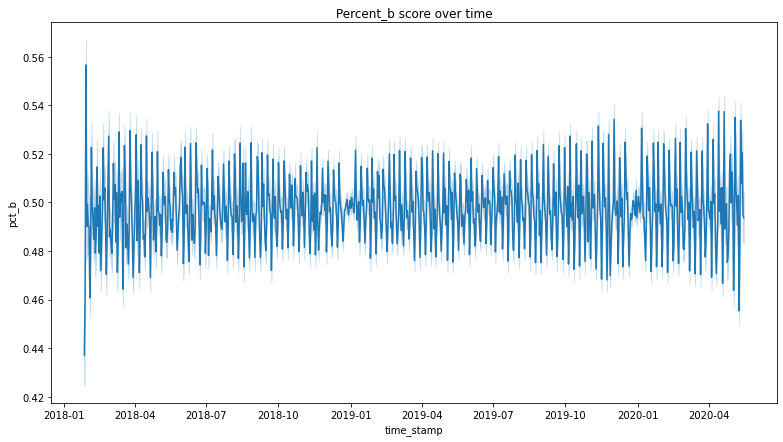

In [31]:
plt.figure(figsize=(13, 7))
sns.lineplot(data=df, x=df.index, y="pct_b")
plt.title("Percent_b score over time")

# What do the different ip addresses look like?

Text(0.5, 1.0, 'Total Number of Destinations by IP address')

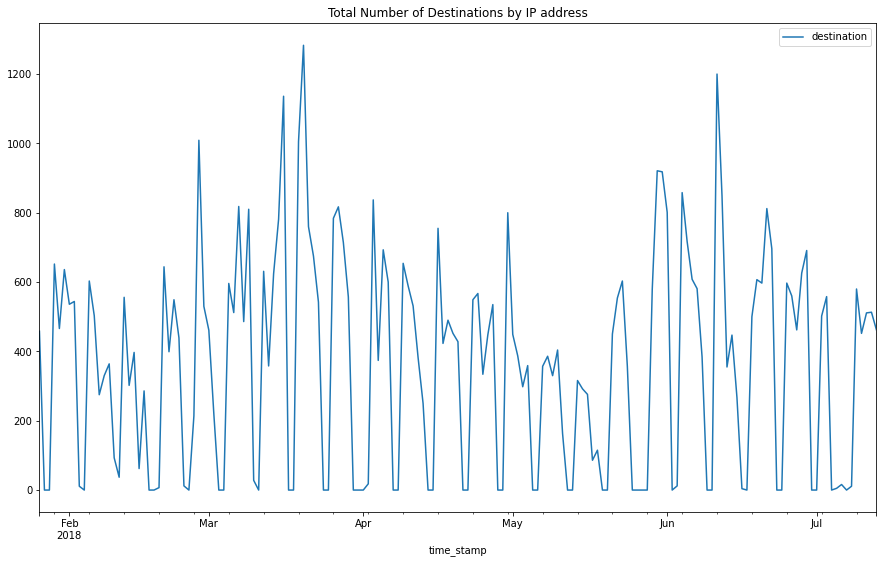

In [32]:
logs[logs.ip == "98.106.20.62"].groupby(["time_stamp"])[["destination"]].count().resample("D").sum().plot.line(figsize=(15,9))
plt.title("Total Number of Destinations by IP address")

Any extreme activities from ip addresses and the number of destinations they are hitting?

In [33]:
df = pd.DataFrame()
ips = logs.ip.value_counts().index
ip = 0
active = True
while active:
    if ip < ips.shape[0]:
        test = logs[logs.ip == ips[ip]].groupby("time_stamp")[["destination"]].count().resample("D").sum()
        value = create_pct_b(test, "destination", 2)
        value["ip"] = ips[ip]
        df = pd.concat([df, value])
        ip += 1
        if df.pct_b[-1] > 1:
            print(f'There is a high anomaly detected in user {ips[ip]} on {df.iloc[-1].name}')
        elif df.pct_b[-1] < 0:
            print(f'There is a low anomaly detected in cohort {ips[ip]} on {df.iloc[-1].name}')
    else:
        active = False

years = ["2018", "2019", "2020"]
for col in years:
    if (df.pct_b > 1).sum() == 0:
        print(f"No anomaly activity detected in {col}")
    elif (df.pct_b > 1).sum() > 0:
        print()
        print(f"Suspicious report(s) in {col}:")
        print("-------")
        print(f"Number of high reports: {df[col][df[col].pct_b >= 1].shape[0]}")
        print(df[col][df[col].pct_b >= 1][["user_id", "ip","target_val", "pct_b"]].sort_values(by="pct_b", ascending=False))
        print()
        print(f"Number of low reports: {df[col][df[col].pct_b < 0].shape[0]}")
        print(df[col][df[col].pct_b < 0][["user_id", "ip","target_val", "pct_b"]].sort_values(by="pct_b", ascending=False))
        print()

No anomaly activity detected in 2018
No anomaly activity detected in 2019
No anomaly activity detected in 2020


In [34]:
# Data frame with number of destinations, per day, by ip
df

,target_val,previous_val,ema,stdev,ub,lb,pct_b,ip
time_stamp,,,,,,,,
2018-07-16,344,0.0,344.000000,NaN,NaN,NaN,NaN,98.106.20.59
2018-07-17,396,344.0,378.666667,36.769553,488.975325,268.358009,0.578567,98.106.20.59
2018-07-18,370,396.0,372.888889,20.961870,435.774499,310.003278,0.477031,98.106.20.59
2018-07-19,244,370.0,286.962963,86.823175,547.432488,26.493438,0.417528,98.106.20.59
2018-07-20,224,244.0,244.987654,65.359662,441.066639,48.908669,0.446482,98.106.20.59
...,...,...,...,...,...,...,...,...
2019-03-19,1,0.0,1.000000,NaN,NaN,NaN,NaN,25.244.60.165
2019-01-06,1,0.0,1.000000,NaN,NaN,NaN,NaN,135.197.132.93
2019-02-08,1,0.0,1.000000,NaN,NaN,NaN,NaN,173.59.110.221


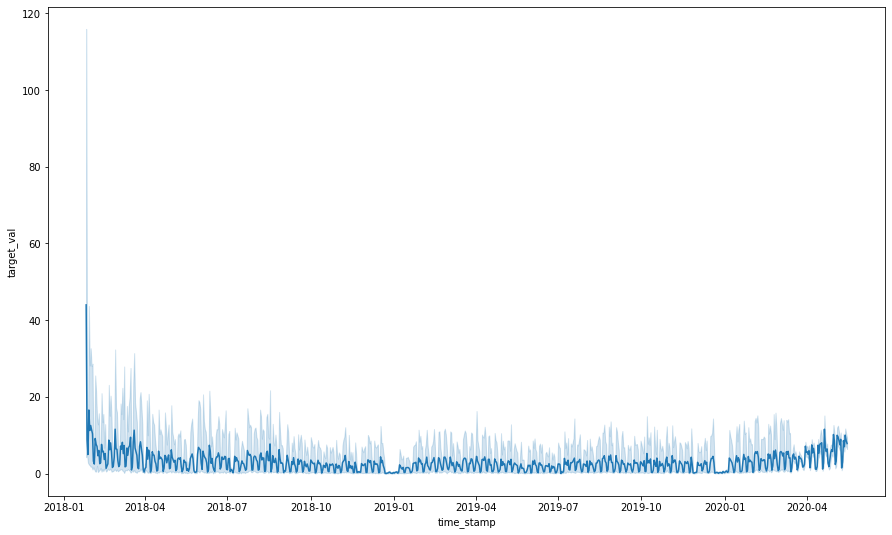

In [35]:
plt.figure(figsize=(15,9))
sns.lineplot(data=df, x=df.index, y="target_val")

Text(0.5, 1.0, 'Number of total destinations over time')

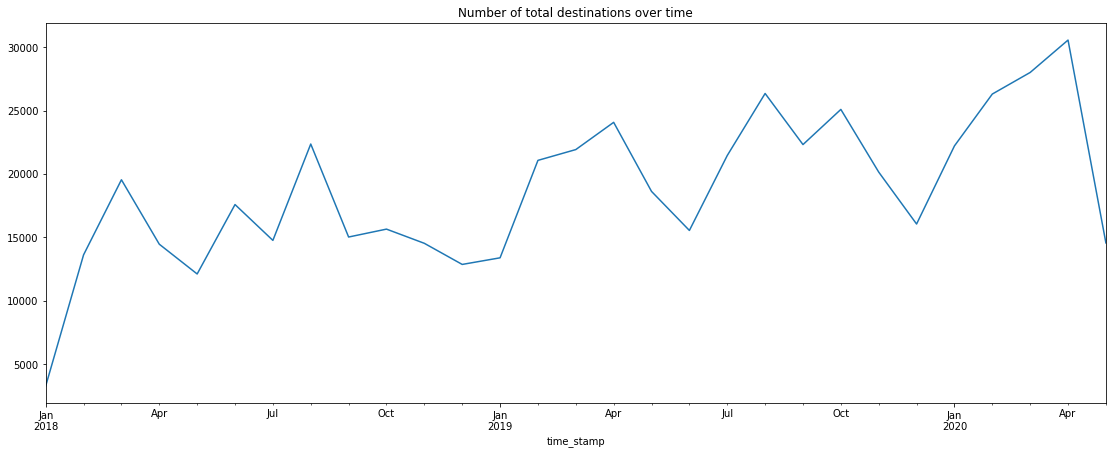

In [36]:
# Is the total number of destinations decreasing over time?

logs.groupby("time_stamp").destination.count().resample("M").sum().plot.line(figsize=(19, 7))
plt.title("Number of total destinations over time")

# Find the number of users per ip address (replace count destination for count ip per user)

In [37]:
df = pd.DataFrame()
users = logs.user_id.value_counts().index.sort_values()
user = 0
active = True
while active:
    if user < users.shape[0]:
        test = logs[logs.user_id == users[user]].groupby("time_stamp")[["ip"]].count().resample("D").sum()
        value = create_pct_b(test, "ip", 2)
        value["user_id"] = users[user]
        df = pd.concat([df, value])
        user += 1
        if df.pct_b[-1] > 1:
            print(f'There is a high anomaly detected in user {users[user]} on {df.iloc[-1].name}')
        elif df.pct_b[-1] < 0:
            print(f'There is a low anomaly detected in cohort {users[user]} on {df.iloc[-1].name}')
    else:
        active = False

years = ["2018", "2019", "2020"]
for col in years:
    if (df.pct_b > 1).sum() == 0:
        print(f"No anomaly activity detected in {col}")
    else:
        print()
        print(f"Suspicious report(s) in {col}:")
        print("-------")
        print(f"Number of high reports: {df[col][df[col].pct_b >= 1].shape[0]}")
        print(df[col][df[col].pct_b >= 1][["user_id","target_val", "pct_b"]].sort_values(by="pct_b", ascending=False))
        print()
        print(f"Number of low reports: {df[col][df[col].pct_b < 0].shape[0]}")
        print(df[col][df[col].pct_b < 0][["user_id","target_val", "pct_b"]].sort_values(by="pct_b", ascending=False))
        print()

No anomaly activity detected in 2018
No anomaly activity detected in 2019
No anomaly activity detected in 2020


In [38]:
# Dataframe for looking at number of ip addresses used by user.
df

,target_val,previous_val,ema,stdev,ub,lb,pct_b,user_id
time_stamp,,,,,,,,
2018-01-26,7,0.0,7.000000,NaN,NaN,NaN,NaN,1
2018-01-27,1,7.0,3.000000,4.242641,15.727922,-9.727922,0.421433,1
2018-01-28,0,1.0,1.000000,3.074085,10.222256,-8.222256,0.445783,1
2018-01-29,6,0.0,4.333333,3.773825,15.654810,-6.988143,0.573606,1
2018-01-30,5,6.0,4.777778,2.222392,11.444953,-1.889397,0.516665,1
...,...,...,...,...,...,...,...,...
2020-05-13,8,29.0,13.544692,12.306105,50.463007,-23.373623,0.424906,648
2020-05-14,24,8.0,20.514897,9.953082,50.374143,-9.344348,0.558359,648
2020-05-15,7,24.0,11.504966,10.686447,43.564306,-20.554375,0.429740,648
